### In this notebook we read in data needed for MARBL and generate 1D input files. 


In [1]:
%reset
%matplotlib inline

import os

import cmocean
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
cesm_in_dir='/glade/work/mlevy/cesm_inputdata/'
GRID_FILE             =  xr.open_dataset(f'{cesm_in_dir}/mom6.static.nc') # time invariant output from a CESM run on the tx0.66v1 grid
OLD_IC_FILE           =  xr.open_dataset(f'{cesm_in_dir}/ecosys_jan_IC_omip_MOM_tx0.66v1_c221027.nc') # Combination of WOA and other fields from POP includes BGC tracers
IC_FILE               =  xr.open_mfdataset(f'{cesm_in_dir}/MOM_IC*.nc', compat='override', join='override', combine_attrs='override').isel(Time=0).drop('Time') # MOM's reported initial conditions from a CESM run on the tx0.66v1 grid
# TS_IC_FILE            =  xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/mom/tx0.66v1/woa18_04_initial_conditions.nc',decode_times=False) #T and S fields

MARBL_FESEDFLUX_FILE  =  xr.open_dataset(f'{cesm_in_dir}/fesedflux_total_reduce_oxic_tx0.66v1.c211109.nc') #From Matt's notebook based on POP output; only has nlon nlat, not actual  lon/lat
MARBL_FEVENTFLUX_FILE =  xr.open_dataset(f'{cesm_in_dir}/feventflux_5gmol_tx0.66v1.c211109.nc') 

#Read in MARBL forcing from A-compset run:
MARBL_FORCING_FILE        =  xr.open_dataset('/glade/work/mlevy/codes/MOM6-examples/gen_forcing_on_tx066v1/MARBL_forcing.nc')

In [3]:
# Mask out land / layers below ocean floor, then drop fields without 'Layer' dimension
for varname in IC_FILE.data_vars:
    if 'Layer' in IC_FILE[varname].dims:
        IC_FILE[varname].data = np.where(np.isfinite(GRID_FILE['deptho'].data),
                                         IC_FILE[varname].data,
                                         np.nan)
IC_FILE = IC_FILE.drop([var for var in IC_FILE.data_vars if 'Layer' not in IC_FILE[var].dims and 'Interface' not in IC_FILE[var].dims])

In [4]:
lat_array = GRID_FILE['geolat']
lon_array = GRID_FILE['geolon']
#print(lat_array)

#We want to extract data at a certain lat/lon point. BATS location is 31.666667N, 64.166667W.
lat =  31.666667 
lon = -64.166667

# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(lat_array-lat)
abslon = np.abs(lon_array-lon)
c = np.maximum(abslat,abslon, )

([yloc],[xloc]) = np.where(c == np.min(c))

print(yloc,xloc)

313 334


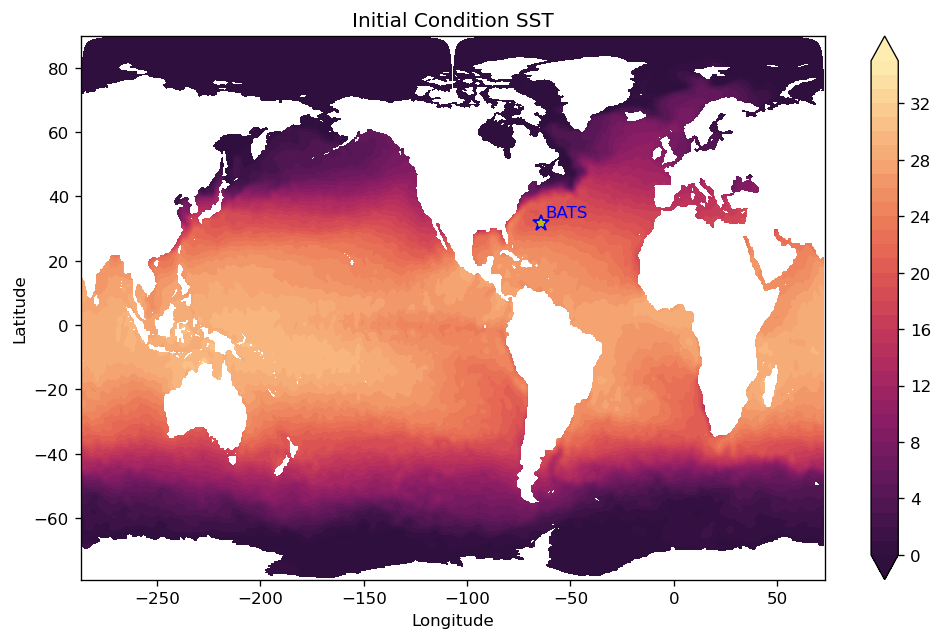

In [5]:
plt.figure(figsize=(10, 6),dpi=120)

plt.contourf(lon_array,lat_array,IC_FILE['Temp'][0,:,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=35,levels=np.linspace(0,35,36),extend='both')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Initial Condition SST')
plt.plot(lon_array[yloc,xloc],lat_array[yloc,xloc],'*b',markersize=10)
# plt.plot(IC_FILE.LON[yloc,xloc],IC_FILE.LAT[yloc,xloc],'*r',markersize=5)
#plt.plot(TS_IC_FILE.lon[ilon_TS],TS_IC_FILE.lat[ilat_TS],'*r',markersize=8)
plt.plot(MARBL_FORCING_FILE.lon[yloc,xloc],MARBL_FORCING_FILE.lat[yloc,xloc],'*y',markersize=5)

plt.text(lon_array[yloc,xloc]+2,lat_array[yloc,xloc]+2,'BATS',color='b')
plt.show()

In [6]:
def set_fill_value(ds):
    '''
    No _FillValue attribute for coordinates, -1e34 for data variables
    '''
    for var in ds.coords:
        ds[var].encoding['_FillValue'] = None
        if 'missing_value' in ds[var].encoding:
            del ds[var].encoding['missing_value']

    for var in ds.data_vars:
        if ds[var].data.dtype in ['float32', 'float64']:
            ds[var].encoding['_FillValue'] = -1.e34
        if 'missing_value' in ds[var].encoding:
            del ds[var].encoding['missing_value']

    return ds

In [7]:
IC_FILE_COLUMN               = IC_FILE.isel(lath=[yloc-1,yloc], lonh=[xloc-1,xloc])#.rename_dims({'lath':'lon','lonh':'lat'})
MARBL_FESEDFLUX_FILE_COLUMN  = MARBL_FESEDFLUX_FILE.isel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})
MARBL_FEVENTFLUX_FILE_COLUMN = MARBL_FEVENTFLUX_FILE.isel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})#.expand_dims(dim={'LAT':1,'LON':1},axis=[1,2])  #leaving braces around [xloc] and [yloc] preserves that dimension

# TS_IC_FILE_COLUMN            = TS_IC_FILE.isel(lat=[ilat_TS-1,ilat_TS],lon=[ilon_TS-1,ilon_TS])

MARBL_FORCING_temp    = MARBL_FORCING_FILE.isel(nlat=[yloc-1,yloc], nlon=[xloc-1,xloc])
#MARBL_FORCING_temp    = MARBL_FORCING_FILE.isel(time = np.arange(0,365), nlat=[yloc-1,yloc], nlon=[xloc-1,xloc])


print(MARBL_FORCING_temp.lat[:,0])
print(MARBL_FORCING_temp.lon[0,:])

#Making some modifications to MARBL_FORCING_FILE_COLUMN:
ds = MARBL_FORCING_temp

ds = ds.rename_dims({'nlat': 'gridlat_t', 'nlon': 'gridlon_t'})
ds = ds.assign_coords({'gridlat_t': MARBL_FORCING_temp.lat[:,0], 'gridlon_t': MARBL_FORCING_temp.lon[0,:]})
ds.gridlat_t.attrs['units'] = 'degree_north'
ds.gridlat_t.attrs['cartesian_axis'] = 'Y'
ds.gridlon_t.attrs['units'] = 'degree_east'
ds.gridlon_t.attrs['cartesian_axis'] = 'X'

#ds.time.encoding['_FillValue'] = 10000000000. 
ds.time.attrs['units'] = "days since 1982-01-01 00:00:00"
ds.time.attrs['time_origin'] = "01-JAN-1982 00:00:00"
ds.time.attrs['calendar'] = 'NOLEAP'
ds.time.attrs['cartesian_axis'] = 'T'
ds.time.attrs['modulo'] = " "
ds.time.attrs['modulo_beg'] = "1982-01-01 00:00:00"
ds.time.attrs['modulo_end'] = "1987-01-01 00:00:00"


ds.gridlon_t.encoding['_FillValue'] = None
ds.gridlat_t.encoding['_FillValue'] = None

MARBL_FORCING_FILE_COLUMN = ds;



<xarray.DataArray 'lat' (nlat: 2)>
array([31.099484, 31.657515])
Coordinates:
    lat      (nlat) float64 ...
    lon      (nlat) float64 ...
Dimensions without coordinates: nlat
Attributes:
    units:    degrees_north
<xarray.DataArray 'lon' (nlon: 2)>
array([-64.682013, -64.015321])
Coordinates:
    lat      (nlon) float64 ...
    lon      (nlon) float64 ...
Dimensions without coordinates: nlon
Attributes:
    units:    degrees_east


In [8]:
#Setting 4 points on the grid to be equal to the first point
# Also update Layer dimension for IC_FILE_COLUMN

fields = list(IC_FILE_COLUMN.data_vars)
for field in fields:
    IC_FILE_COLUMN[field][:,1,0]=IC_FILE_COLUMN[field][:,0,0]
    IC_FILE_COLUMN[field][:,0,1]=IC_FILE_COLUMN[field][:,0,0]
    IC_FILE_COLUMN[field][:,1,1]=IC_FILE_COLUMN[field][:,0,0]
# Compute depth variable for IC_FILE_COLUMN
# assign coordinates to match DataSet
depth = -0.5*(IC_FILE_COLUMN.eta[:-1,:,:].rename(Interface='Layer').assign_coords(Layer=IC_FILE_COLUMN['Layer'].values) +
              IC_FILE_COLUMN.eta[1:,:,:].rename(Interface='Layer').assign_coords(Layer=IC_FILE_COLUMN['Layer'].values)).rename('depth')
IC_FILE_COLUMN = IC_FILE_COLUMN.assign_coords({'Layer': depth.isel(lath=0,lonh=0).values})
IC_drop_vars = ['h', 'u', 'v', 'u2', 'v2', 'CAu', 'CAv', 'diffu', 'diffv', 'age', 'Kd_shear', 'Kv_shear', 'MARBL_PH_3D', 'MARBL_PH_3D_ALT_CO2']
for var in IC_drop_vars:
    IC_FILE_COLUMN = IC_FILE_COLUMN.drop(var)

fields = ['FESEDFLUXIN','FESEDFLUXIN_oxic','FESEDFLUXIN_reduce']
for field in fields:
    MARBL_FESEDFLUX_FILE_COLUMN[field][:,1,0]=MARBL_FESEDFLUX_FILE_COLUMN[field][:,0,0]
    MARBL_FESEDFLUX_FILE_COLUMN[field][:,0,1]=MARBL_FESEDFLUX_FILE_COLUMN[field][:,0,0]
    MARBL_FESEDFLUX_FILE_COLUMN[field][:,1,1]=MARBL_FESEDFLUX_FILE_COLUMN[field][:,0,0]
MARBL_FESEDFLUX_FILE_COLUMN = set_fill_value(MARBL_FESEDFLUX_FILE_COLUMN)

fields = ['FESEDFLUXIN']
for field in fields:
    MARBL_FEVENTFLUX_FILE_COLUMN[field][:,1,0]=MARBL_FEVENTFLUX_FILE_COLUMN[field][:,0,0]
    MARBL_FEVENTFLUX_FILE_COLUMN[field][:,0,1]=MARBL_FEVENTFLUX_FILE_COLUMN[field][:,0,0]
    MARBL_FEVENTFLUX_FILE_COLUMN[field][:,1,1]=MARBL_FEVENTFLUX_FILE_COLUMN[field][:,0,0]
MARBL_FEVENTFLUX_FILE_COLUMN = set_fill_value(MARBL_FEVENTFLUX_FILE_COLUMN)

# fields = list(TS_IC_FILE_COLUMN.keys())
# for field in fields:
#     TS_IC_FILE_COLUMN[field][:,1,0]=TS_IC_FILE_COLUMN[field][:,0,0]
#     TS_IC_FILE_COLUMN[field][:,0,1]=TS_IC_FILE_COLUMN[field][:,0,0]
#     TS_IC_FILE_COLUMN[field][:,1,1]=TS_IC_FILE_COLUMN[field][:,0,0]

fields = list(MARBL_FORCING_FILE_COLUMN.keys())
for field in fields:
    MARBL_FORCING_FILE_COLUMN[field][:,1,0]=MARBL_FORCING_FILE_COLUMN[field][:,0,0]
    MARBL_FORCING_FILE_COLUMN[field][:,0,1]=MARBL_FORCING_FILE_COLUMN[field][:,0,0]
    MARBL_FORCING_FILE_COLUMN[field][:,1,1]=MARBL_FORCING_FILE_COLUMN[field][:,0,0]
MARBL_FORCING_FILE_COLUMN = set_fill_value(MARBL_FORCING_FILE_COLUMN)

In [9]:
##Modifications so that we use Kristen's 4p2z model:
print(IC_FILE_COLUMN)

IC_FILE_COLUMN = IC_FILE_COLUMN.rename({'lath': 'lat', 'lonh': 'lon'})

IC_FILE_COLUMN['coccoC'] = IC_FILE_COLUMN['spC'] * 0.07
IC_FILE_COLUMN['coccoFe'] = IC_FILE_COLUMN['spFe'] * 0.07
IC_FILE_COLUMN['coccoP'] = IC_FILE_COLUMN['spP'] * 0.07
IC_FILE_COLUMN['coccoChl'] = IC_FILE_COLUMN['spChl'] * 0.07

# and then reduce the sp pools so biomass is conserved:
IC_FILE_COLUMN['spC'] = IC_FILE_COLUMN['spC'] * 0.93
IC_FILE_COLUMN['spFe'] = IC_FILE_COLUMN['spFe'] * 0.93
IC_FILE_COLUMN['spP'] = IC_FILE_COLUMN['spP'] * 0.93
IC_FILE_COLUMN['spChl'] = IC_FILE_COLUMN['spChl'] * 0.93

#For coccoCaCO3, just set that equal to spCaCO3:
IC_FILE_COLUMN['coccoCaCO3'] = IC_FILE_COLUMN['spCaCO3']
#and then drop spCaCO3 (it's not a tracer in Kristen's 4p2z version of MARBL)
IC_FILE_COLUMN = IC_FILE_COLUMN.drop(['spCaCO3'])

IC_FILE_COLUMN['mesozooC'] = IC_FILE_COLUMN['zooC'] * 0.56
IC_FILE_COLUMN['microzooC'] = IC_FILE_COLUMN['zooC'] * 0.44
#and then drop zooC:
IC_FILE_COLUMN = IC_FILE_COLUMN.drop(['zooC'])

IC_FILE_COLUMN = set_fill_value(IC_FILE_COLUMN)
print(IC_FILE_COLUMN)

<xarray.Dataset>
Dimensions:      (lath: 2, lonh: 2, latq: 458, lonq: 540, Layer: 65,
                  Interface: 66)
Coordinates:
  * lath         (lath) float64 31.18 31.75
  * lonh         (lonh) float64 -64.67 -64.0
  * latq         (latq) float64 -79.14 -79.01 -78.89 ... 87.68 87.73 87.74
  * lonq         (lonq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.67 72.33 73.0
  * Layer        (Layer) float64 1.25 3.75 6.25 ... 4.523e+03 4.523e+03
  * Interface    (Interface) float64 0.0 2.5 5.0 ... 5.503e+03 5.751e+03 6e+03
Data variables: (12/35)
    Temp         (Layer, lath, lonh) float64 dask.array<chunksize=(65, 2, 2), meta=np.ndarray>
    Salt         (Layer, lath, lonh) float64 dask.array<chunksize=(65, 2, 2), meta=np.ndarray>
    PO4          (Layer, lath, lonh) float64 dask.array<chunksize=(65, 2, 2), meta=np.ndarray>
    NO3          (Layer, lath, lonh) float64 dask.array<chunksize=(65, 2, 2), meta=np.ndarray>
    SiO3         (Layer, lath, lonh) float64 dask.array<chunksize=(6

In [10]:
keys = [key for key in IC_FILE_COLUMN.keys() if 'Layer' in IC_FILE_COLUMN[key].dims]
len(keys)

39

In [11]:
keys

['Temp',
 'Salt',
 'PO4',
 'NO3',
 'SiO3',
 'NH4',
 'Fe',
 'Lig',
 'O2',
 'DIC',
 'DIC_ALT_CO2',
 'ALK',
 'ALK_ALT_CO2',
 'DOC',
 'DON',
 'DOP',
 'DOPr',
 'DONr',
 'DOCr',
 'spChl',
 'spC',
 'spP',
 'spFe',
 'diatChl',
 'diatC',
 'diatP',
 'diatFe',
 'diatSi',
 'diazChl',
 'diazC',
 'diazP',
 'diazFe',
 'coccoC',
 'coccoFe',
 'coccoP',
 'coccoChl',
 'coccoCaCO3',
 'mesozooC',
 'microzooC']

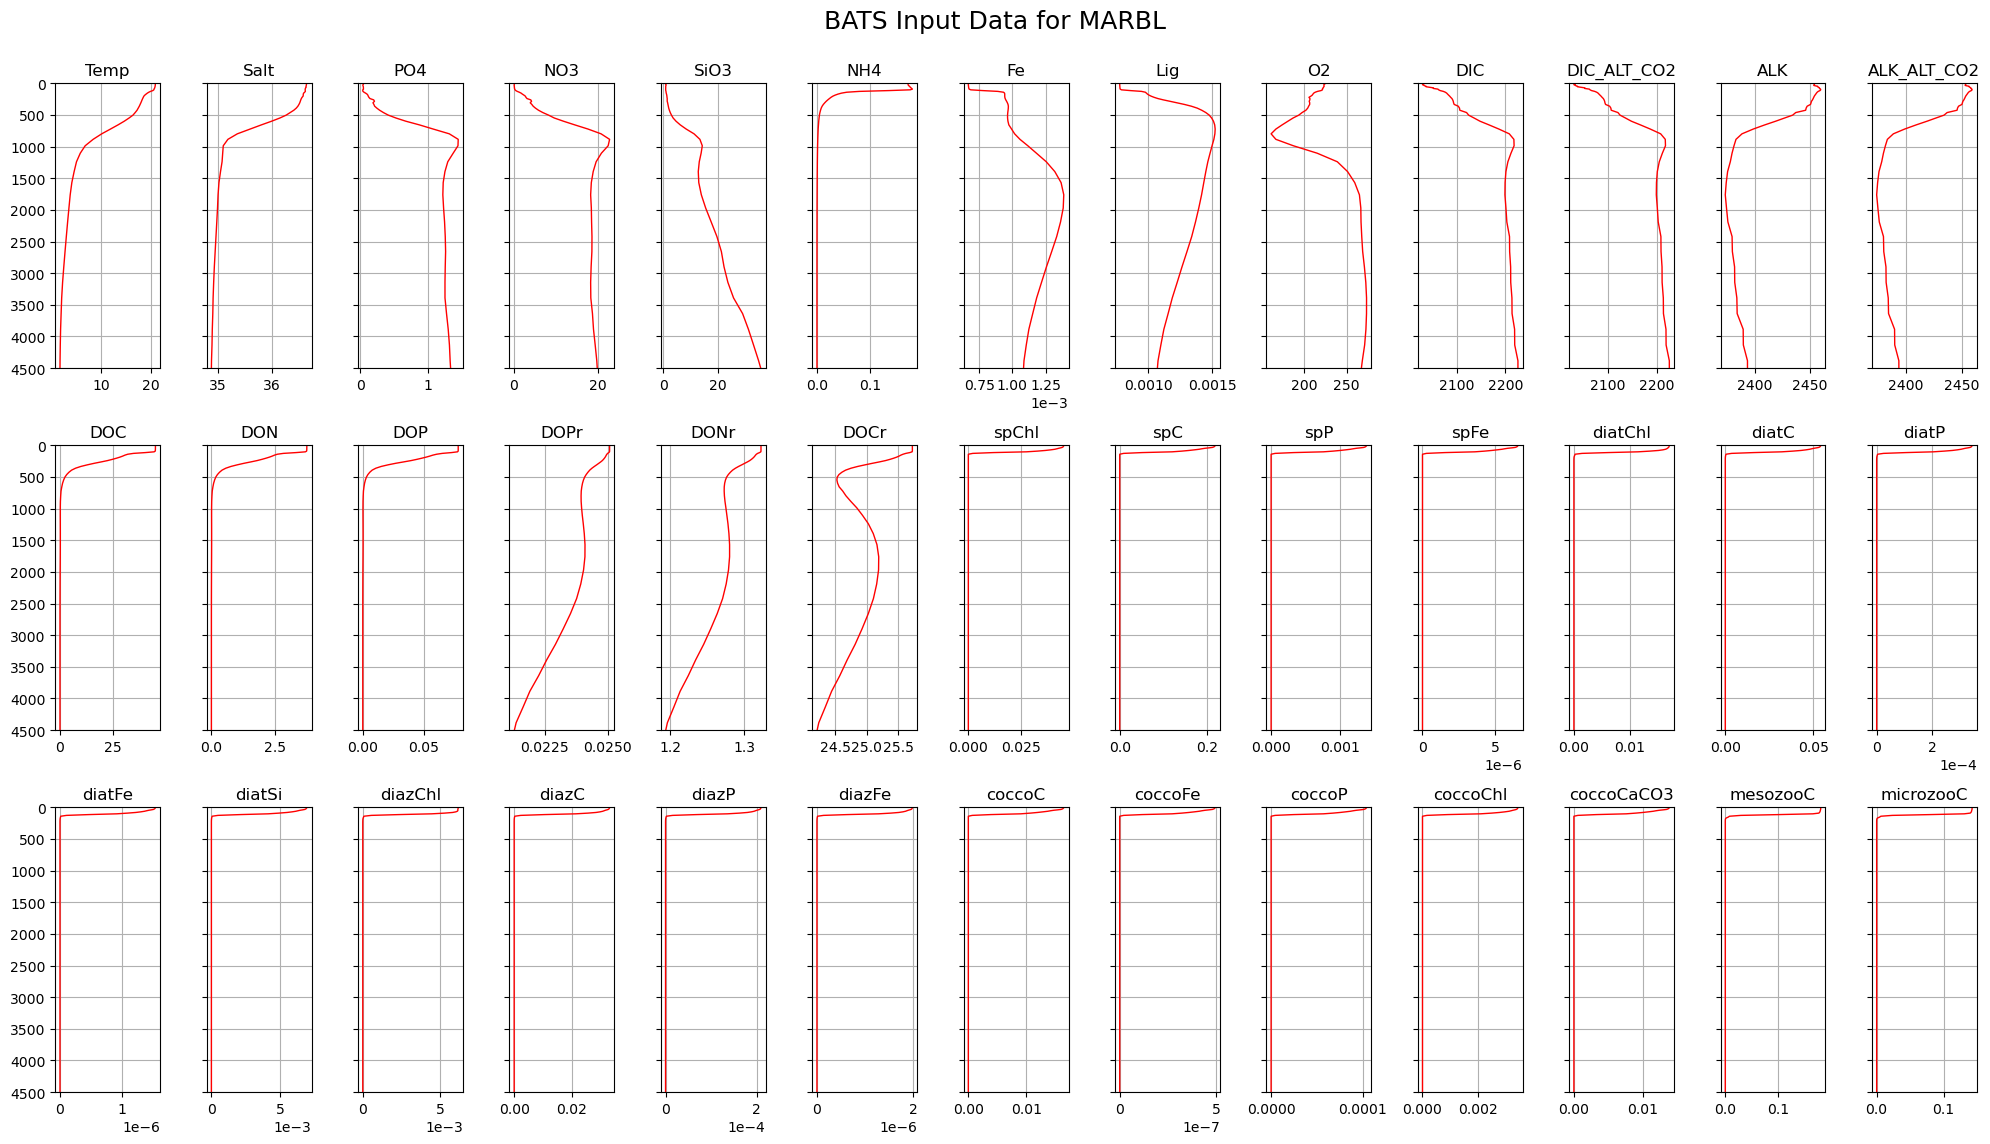

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=13, figsize=(20, 12), sharey = True, dpi=100)
fig.suptitle("BATS Input Data for MARBL", fontsize=18, y=0.95)

for key, ax in zip(keys, axs.ravel()):
    ax.plot(IC_FILE_COLUMN[key][:,0,0],IC_FILE_COLUMN.Layer,'r',linewidth=1)

    ax.set_ylim([4500, 0])
    ax.set_title(key)
    ax.grid()
    #ax.set_xlabel(IC_FILE_COLUMN[key].units)
    ax.ticklabel_format(style='plain', axis='x')
    if key in ['spFe','diatFe','diatSi','diazChl','diatP','diazFe','diazP','Fe','coccoFe']:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#fig.delaxes(axs[-1][-1])
#fig.delaxes(axs[-1][-2])
fig.tight_layout(rect=[0, 0, 1, 0.95])


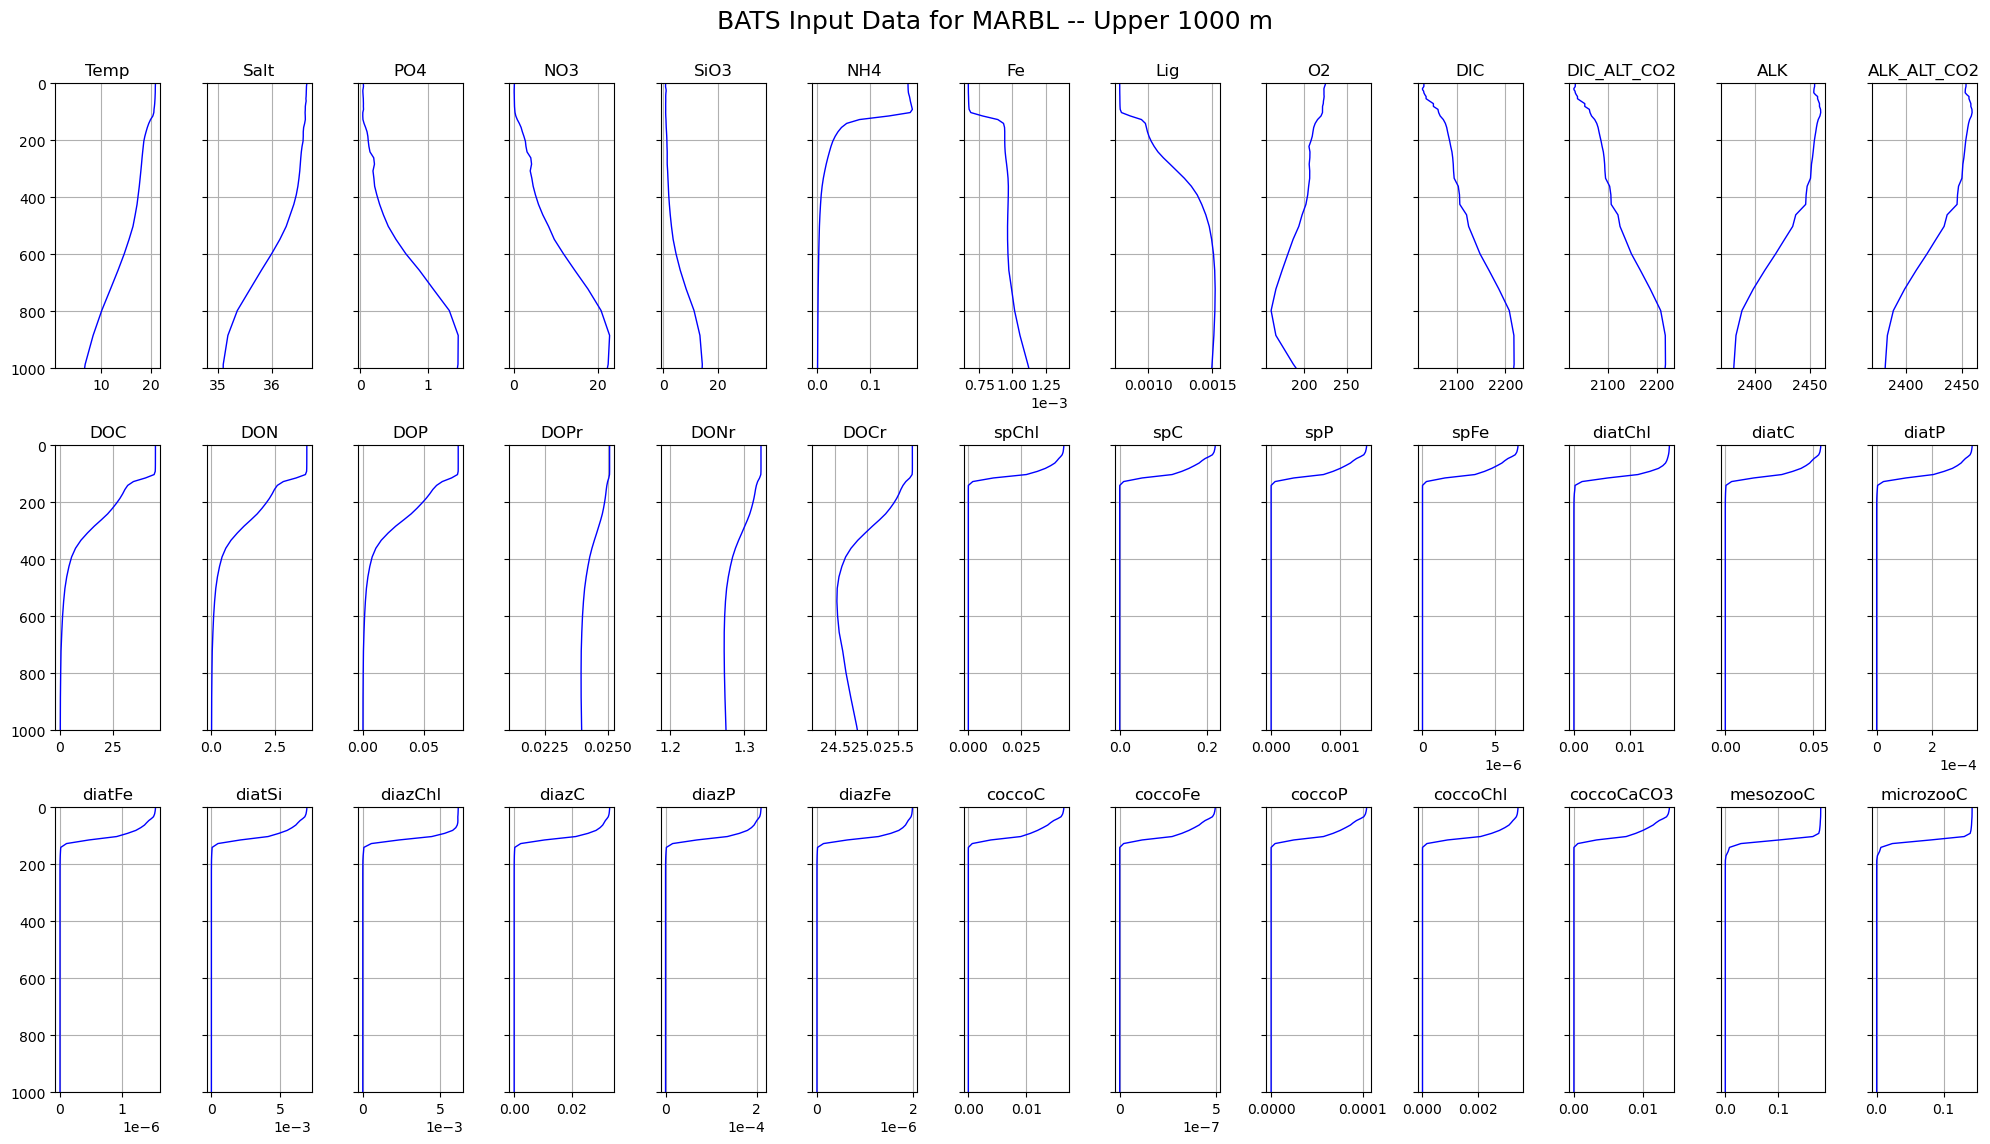

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=13, figsize=(20, 12), sharey = True, dpi=100)
fig.suptitle("BATS Input Data for MARBL -- Upper 1000 m", fontsize=18, y=0.95)

for key, ax in zip(keys, axs.ravel()):
    ax.plot(IC_FILE_COLUMN[key][:,0,0],IC_FILE_COLUMN.Layer,'b',linewidth=1)

    ax.set_ylim([1000, 0])
    ax.set_title(key)
    ax.grid()
    #ax.set_xlabel(IC_FILE_COLUMN[key].units)
    ax.ticklabel_format(style='plain', axis='x')
    if key in ['spFe','diatFe','diatSi','diazChl','diatP','diazFe','diazP','Fe','coccoFe']:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#fig.delaxes(axs[-1][-1])
#fig.delaxes(axs[-1][-2])
fig.tight_layout(rect=[0, 0, 1, 0.95])

## Adding SST and SSS restoring to the MARBL_FORCING_FILE_COLUMN:

In [14]:
initial_salt = np.nanmean(IC_FILE_COLUMN.Salt[0,:])
initial_temp = np.nanmean(IC_FILE_COLUMN.Temp[0,:])
print(initial_salt, initial_temp)

36.655915287901344 20.867275743831517


In [15]:

SST_RESTORE = MARBL_FORCING_FILE_COLUMN.SWDN*0.0+15
SSS_RESTORE = MARBL_FORCING_FILE_COLUMN.SWDN*0.0+35

MARBL_FORCING_FILE_COLUMN['SST_RESTORE'] = MARBL_FORCING_FILE_COLUMN['SWDN'] * 0. + initial_temp
MARBL_FORCING_FILE_COLUMN['SSS_RESTORE'] = MARBL_FORCING_FILE_COLUMN['SWDN'] * 0. + initial_salt

print(MARBL_FORCING_FILE_COLUMN)

<xarray.Dataset>
Dimensions:               (time: 1825, gridlat_t: 2, gridlon_t: 2, nlat: 2,
                           nlon: 2)
Coordinates:
  * time                  (time) float64 0.5 1.5 2.5 ... 1.824e+03 1.824e+03
    lat                   (gridlat_t, gridlon_t) float64 ...
    lon                   (gridlat_t, gridlon_t) float64 ...
    gridlat_t             (nlat) float64 ...
    gridlon_t             (nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables: (12/19)
    ATM_FINE_DUST_FLUX    (time, gridlat_t, gridlon_t) float64 5.759e-14 ... ...
    ATM_COARSE_DUST_FLUX  (time, gridlat_t, gridlon_t) float64 1.86e-12 ... 1...
    ATM_BC_FLUX           (time, gridlat_t, gridlon_t) float64 1.22e-13 ... 1...
    SEAICE_DUST_FLUX      (time, gridlat_t, gridlon_t) float64 0.0 0.0 ... 0.0
    SEAICE_BC_FLUX        (time, gridlat_t, gridlon_t) float64 0.0 0.0 ... 0.0
    U10_SQR               (time, gridlat_t, gridlon_t) float64 22.03 ... 269.5
    ...               

## Finally save the MARBL column input files within the BATS input directory in single_column example directory

In [16]:
#%cd /glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/INPUT/BATS/
USER = os.environ['USER']
if  USER == 'eyankovsky':
    out_dir = '/glade/u/home/eyankovsky/CESM/cesm2_3_alpha12b+mom6_marbl/components/mom/standalone/examples/single_column/INPUT/CESM_MOM_COLUMNS/BATS'
elif USER == 'mlevy':
    out_dir = '/glade/work/mlevy/codes/CESM/cesm2_3_alpha12b+mom6_marbl/components/mom/standalone/examples/single_column/INPUT/CESM_MOM_COLUMNS/BATS'
else:
    print(f'Can not find output directory for {USER}, writing netcdf in current dir')
    out_dir = '.'

# remove existing copies of output files
for file in['IC_FILE_COLUMN.nc', 'MARBL_FESEDFLUX_FILE_COLUMN.nc', 'MARBL_FEVENTFLUX_FILE_COLUMN.nc', 'MARBL_FORCING_FILE_COLUMN.nc']:
    full_path = f'{out_dir}/{file}'
    try:
        os.remove(full_path)
    except FileNotFoundError:
        print(f'{full_path} does not exist')

IC_FILE_COLUMN.drop('eta').to_netcdf(f'{out_dir}/IC_FILE_COLUMN.nc', 'w')

# TS_IC_FILE_COLUMN.to_netcdf(f'{out_dir}/TS_IC_FILE_COLUMN.nc', 'w')

MARBL_FESEDFLUX_FILE_COLUMN.to_netcdf(f'{out_dir}/MARBL_FESEDFLUX_FILE_COLUMN.nc','w')
MARBL_FEVENTFLUX_FILE_COLUMN.to_netcdf(f'{out_dir}/MARBL_FEVENTFLUX_FILE_COLUMN.nc','w')

MARBL_FORCING_FILE_COLUMN.to_netcdf(f'{out_dir}/MARBL_FORCING_FILE_COLUMN.nc','w',unlimited_dims='time')
#
_ = os.system(f'ls {out_dir}')



forcing_monthly.nc
forcing.nc
IC_FILE_COLUMN.nc
IC_FILE_COLUMN.new.nc
MARBL_FESEDFLUX_FILE_COLUMN.nc
MARBL_FEVENTFLUX_FILE_COLUMN.nc
MARBL_FORCING_FILE_COLUMN.nc
MOM_override
new
unused
WOA_column.nc


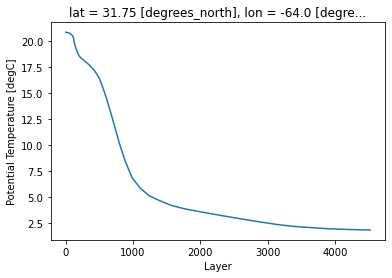

In [17]:
testing_IC_FILE = xr.open_dataset(f'{out_dir}/IC_FILE_COLUMN.nc',decode_times=False)
#testing_ICs = xr.open_dataset('ICs.nc')
testing_IC_FILE.Temp[:,1,1].plot()

In [ ]:
#(1/1.5854895991882293e-08)/86400/365

## Restoring timescale

In [ ]:
# restoring = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v6/forcing/ecosys_restore_inv_tau_POP_gx1v6_20170125.nc')

# #print(restoring.RESTORE_INV_TAU )

# print('max restoring inverse timescale in years is:',(1/(np.nanmax(restoring.RESTORE_INV_TAU)))/86400/365)

In [ ]:

# plt.plot(restoring.depth,restoring.RESTORE_INV_TAU[:,100,100])

# plt.plot(restoring.depth,restoring.RESTORE_INV_TAU[:,100,100]*np.tanh(restoring.depth/500))


In [ ]:
# restoring['RESTORE_INV_TAU'] = restoring.RESTORE_INV_TAU*np.tanh(restoring.depth/500)
# restoring['RESTORE_INV_TAU_MARGINAL_SEA_ONLY'] = restoring.RESTORE_INV_TAU_MARGINAL_SEA_ONLY*np.tanh(restoring.depth/500)


In [ ]:
# %cd /glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/KPP_MARBL/INPUT/BATS/
# %rm restoring_3D.nc

# restoring.to_netcdf('restoring_3D.nc','w')
# test = xr.open_dataset('restoring_3D.nc')
# print(test)

In [ ]:
# plt.plot(test.depth,test.RESTORE_INV_TAU[:,50,50])


In [ ]:
IC_FILE_COLUMN.TEMP[:,0,0].plot()